In [1]:
import numpy as np
rng = np.random.default_rng(seed = 37)

import matplotlib.pyplot as plt
import os
import math 
import torch as t
import torch.nn as nn
import torch.nn.functional as F
import torchvision as tv
from torchvision.transforms import v2

from tqdm import tqdm

import sys
sys.path.append('utils')

device = t.device("cuda") if t.cuda.is_available() else t.device("cpu")
print(f'Using {device} for inference')

Using cuda for inference


In [2]:
visualization_transforms = v2.Compose(
    [v2.ToImage(),
     v2.ToDtype(t.float32, scale=True),
     v2.Resize(256),
     v2.CenterCrop(224),
     ])

fav_pic_index = 28621
data_root = 'imagenet'
imagenet_val_visual = tv.datasets.ImageNet(data_root, split = 'val', transform = visualization_transforms)
fav_image = imagenet_val_visual[fav_pic_index][0]

toImage = v2.ToPILImage()

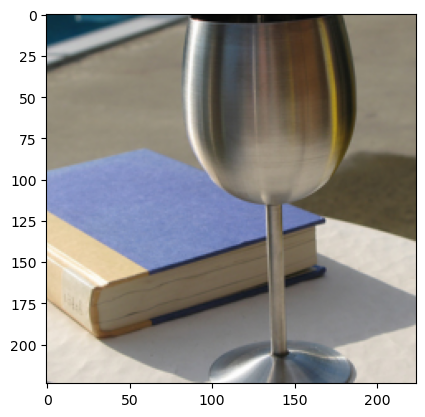

In [3]:
plt.imshow(toImage(fav_image))

In [4]:
from utils.diffeo_container import sparse_diffeo_container


sparse_diffeos = sparse_diffeo_container(224, 224)
time = t.linspace(0, math.pi, 180)
At = np.transpose(np.array([[t.sin(2 * time)/4, (-t.abs(time - math.pi/2)+math.pi/2)/3],[-t.sin(time)**2 / 4, -time*t.sin(time)**2 / 5]]), (2,0,1))
Bt = np.transpose(np.array([[(-t.abs(time - math.pi/2)+math.pi/2)/4 ,time*t.sin(time)**2 / 5],[t.sin(2 * time)/4, -t.sin(time)**2 / 4]]), (2,0,1))

sparse_diffeos.A.append(At)
sparse_diffeos.B.append(Bt)

sparse_diffeos.get_all_grid()

sparse_diffeos.to(device)

sparse_diffeos.get_inverse_grid()

  0%|          | 0/10000 [00:00<?, ?it/s]/home/xj2173/vast/miniconda3/envs/diffeo/lib/python3.11/site-packages/torch/nn/functional.py:4343: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
 33%|███▎      | 3259/10000 [00:04<00:08, 761.12it/s]


diffeo_container(x_res=224, y_res=224, with 180 diffeos)

In [6]:
loop_path = t.nn.functional.grid_sample(fav_image.unsqueeze(0).repeat(len(sparse_diffeos),1,1,1), sparse_diffeos[0])

In [42]:
images = []
for image in loop_path:
    images.append(toImage(image))

images[0].save('../data/output.gif', save_all=True, append_images=images[1:], duration=1.5, loop=0)

In [24]:
inv_loop_path = t.nn.functional.grid_sample(loop_path, inv_grid.cpu())

In [25]:
inv_images = []
for image in inv_loop_path:
    inv_images.append(toImage(image))

inv_images[0].save('../data/inv_output.gif', save_all=True, append_images=inv_images[1:], duration=1.5, loop=0)

In [5]:
activation = {}
def getActivation(name):
    # the hook signature
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook
handles = []

def retrieve_layer_activation(model, input, layer_index):
  if len(input) == 3: input = input[None, :, :, :]

  layers = list(model.children())
  layers_flat = flatten(layers)

  for index in layer_index:
    handles.append(layers_flat[index - 1].register_forward_hook(getActivation(str(index))))

  with t.no_grad(): model(input)
  for handle in handles: handle.remove()

  return

def flatten(array):
    result = []
    for element in array:
        if hasattr(element, "__iter__"):
            result.extend(flatten(element))
        else:
            result.append(element)
    return result

In [6]:
ENV2 = tv.models.efficientnet_v2_s(weights = tv.models.EfficientNet_V2_S_Weights.DEFAULT).to(device)
ENV2.eval();
for param in ENV2.parameters():
    param.requires_grad = False
inference_transform = tv.models.EfficientNet_B0_Weights.IMAGENET1K_V1.transforms()
inference_transforms = v2.Compose([
    lambda x: x.convert('RGB'),
    inference_transform,
])
imagenet_val_inference = tv.datasets.ImageNet(data_root, split = 'val', transform = inference_transforms)
fav_pic_inf = imagenet_val_inference[fav_pic_index][0].unsqueeze(0)

In [7]:
goblet_range = list(range(28600, 28650))
goblet_range.remove(fav_pic_index)
images = t.stack([imagenet_val_inference[index][0] for index in goblet_range])

In [8]:
loop_path = []
for img in images:
    loop_path.append(F.grid_sample(img.repeat(sparse_diffeos.length,1,1,1), sparse_diffeos[0].cpu()))
loop_path = t.stack(loop_path)
loop_path = t.transpose(loop_path, 0, 1)

In [9]:
from copy import deepcopy

distort_activation = []
for img in loop_path:
    retrieve_layer_activation(ENV2, img.to(device), [5])
    distort_activation.append(deepcopy(activation['5']))
    img.cpu()

distort_activation = t.stack(distort_activation)

ref_activation = []
retrieve_layer_activation(ENV2, images.to(device), [5])
ref_activation = deepcopy(activation['5'])


test_loop = F.grid_sample(fav_pic_inf.repeat(sparse_diffeos.length,1,1,1).to(device), sparse_diffeos[0])
retrieve_layer_activation(ENV2, test_loop, [5])
test_act = deepcopy(activation['5'])

In [11]:
ref_activation.shape

torch.Size([49, 24, 112, 112])

In [9]:
down_sampled = sparse_diffeos.inverse.up_down_sample(112, 112)
down_sampled.to(device)

/home/xj2173/vast/miniconda3/envs/diffeo/lib/python3.11/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1712608853085/work/aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [10]:
undiff = []
for img in t.transpose(distort_activation, 0 , 1):
    undiff.append(F.grid_sample(img.cpu(), down_sampled[0].cpu()))
undiff = t.transpose(t.stack(undiff), 0 ,1)

undiff_test = F.grid_sample(test_act,down_sampled[0])

In [16]:
from utils.distortion import mix_channel_2d

test_result = []
i = 0
for diffeo in tqdm(undiff.to(device)):
    h_inverse = mix_channel_2d(24, 112, 112).to(device)
    loss_fn = nn.MSELoss()
    optimizer = t.optim.Adam(h_inverse.parameters(), lr = 0.005)
    num_epochs = 2500
    for epoch in (range(num_epochs)):
        optimizer.zero_grad()
        output = h_inverse(diffeo)
        loss = loss_fn(output, ref_activation)
        loss.backward()
        optimizer.step()

        #diffeo.cpu()

    with t.no_grad():
        test_result.append(h_inverse(undiff_test[i]).detach().clone())
        i += 1
    
    del h_inverse

t.save(test_result, 'data/h_inverse/test_result.pt')

 27%|██▋       | 49/180 [08:08<21:44,  9.96s/it]


OutOfMemoryError: CUDA out of memory. Tried to allocate 208.00 MiB. GPU 

In [3]:
test_result = t.load('data/h_inverse/test_result.pt', map_location = t.device('cpu'))

In [9]:
real_test_result = []
for i, result in enumerate(test_result):
    real_test_result.append(result[i])
real_test_result = t.stack(real_test_result)

In [11]:
real_test_result.shape

torch.Size([180, 24, 112, 112])

In [5]:
test_result[0].shape

torch.Size([180, 24, 112, 112])

In [14]:
for j, image in enumerate(real_test_result):
    fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(10, 10))
    fig.subplots_adjust(right=0.85)

    # Create a shared colorbar
    vmin = -5
    vmax = 20
    cmap = plt.get_cmap('viridis')

    for i, ax in enumerate(axes.flat):
        im = ax.imshow(image[i], vmin=vmin, vmax=vmax, cmap=cmap)
        # if i == 0: im = ax.imshow(images[j])
        ax.set_xticks([])
        ax.set_yticks([])

    # Adjust the colorbar to be placed correctly
    cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    fig.suptitle('h-inverse layer 5', y=0.9)
    plt.savefig(f'process_data/h_inverse_{j:03}.png')
    plt.close()

In [15]:
from PIL import Image

file_names = [f"process_data/h_inverse_{i:03}.png" for i in range(180)]

# Read images and create animation
h_inverse = [Image.open(f) for f in file_names]

# Adjust the fps value as needed
h_inverse[0].save('process_data/h_inverse.gif', save_all=True, append_images=h_inverse[1:], duration=1.5, loop=0)

In [ ]:
for j, image in enumerate(real_test_result):
    fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(10, 10))
    fig.subplots_adjust(right=0.85)

    # Create a shared colorbar
    vmin = -5
    vmax = 20
    cmap = plt.get_cmap('viridis')

    for i, ax in enumerate(axes.flat):
        im = ax.imshow(image[i], vmin=vmin, vmax=vmax, cmap=cmap)
        # if i == 0: im = ax.imshow(images[j])
        ax.set_xticks([])
        ax.set_yticks([])

    # Adjust the colorbar to be placed correctly
    cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    fig.suptitle('h-inverse layer 5', y=0.9)
    plt.savefig(f'process_data/h_inverse_{j:03}.png')
    plt.close()

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
fig.subplots_adjust(right=0.85)

# Create a shared colorbar
vmin = min(d.min() for d in image[::5]) * 0.85
vmin = -17
vmax = max(d.max() for d in image[::5]) * 0.85
vmax = 17
cmap = plt.get_cmap('viridis')

for i, ax in enumerate(axes.flat):
    im = ax.imshow(image[::5][i].T, vmin=vmin, vmax=vmax, cmap=cmap)
    if i == 0: im = ax.imshow(images[j])
    ax.set_xticks([])
    ax.set_yticks([])

# Adjust the colorbar to be placed correctly
cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.7])
fig.colorbar(im, cax=cbar_ax)
fig.suptitle('Layer 9 activation after inverse transformation', y=0.9)

In [126]:
for j, image in enumerate(activation_layer_9_inv):
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
    fig.subplots_adjust(right=0.85)

    # Create a shared colorbar
    vmin = min(d.min() for d in image[::5]) * 0.85
    vmin = -17
    vmax = max(d.max() for d in image[::5]) * 0.85
    vmax = 17
    cmap = plt.get_cmap('viridis')

    for i, ax in enumerate(axes.flat):
        im = ax.imshow(image[::5][i].T, vmin=vmin, vmax=vmax, cmap=cmap)
        if i == 0: im = ax.imshow(images[j])
        ax.set_xticks([])
        ax.set_yticks([])

    # Adjust the colorbar to be placed correctly
    cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    fig.suptitle('Layer 9 activation after inverse transformation', y=0.9)
    plt.savefig(f'../data/temp_layer9/figure_layer9_{j:03}.png')
    plt.close()

In [128]:
from PIL import Image

file_names = [f"../data/temp_layer9/figure_layer9_{i:03}.png" for i in range(180)]

# Read images and create animation
layer_9_images = [Image.open(f) for f in file_names]

# Adjust the fps value as needed
layer_9_images[0].save('../data/layer9_inv_output.gif', save_all=True, append_images=layer_9_images[1:], duration=1.5, loop=0)

In [127]:
for j, image in enumerate(activation_layer_13_inv):
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
    fig.subplots_adjust(right=0.85)

    # Create a shared colorbar
    vmin = min(d.min() for d in image[::4]) * 0.85
    vmin = -17
    vmax = max(d.max() for d in image[::4]) * 0.85
    vmax = 17
    cmap = plt.get_cmap('viridis')

    for i, ax in enumerate(axes.flat):
        im = ax.imshow(image[::4][i].T, vmin=vmin, vmax=vmax, cmap=cmap)
        if i == 0: im = ax.imshow(images[j])
        ax.set_xticks([])
        ax.set_yticks([])

    # Adjust the colorbar to be placed correctly
    cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    fig.suptitle('Layer 13 activation after inverse transformation', y=0.9)
    plt.savefig(f'../data/temp_layer13/figure_layer13_{j:03}.png')
    plt.close()

In [129]:
from PIL import Image

file_names = [f"../data/temp_layer13/figure_layer13_{i:03}.png" for i in range(180)]

# Read images and create animation
layer_13_images = [Image.open(f) for f in file_names]

# Adjust the fps value as needed
layer_13_images[0].save('../data/layer13_inv_output.gif', save_all=True, append_images=layer_13_images[1:], duration=1.5, loop=0)

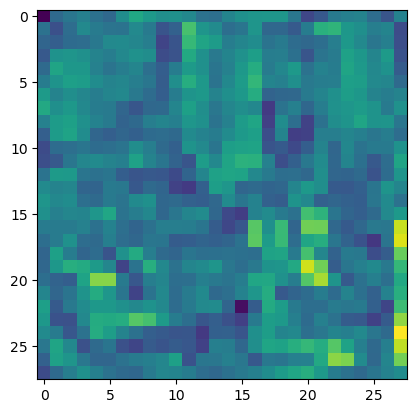

In [78]:
plt.imshow(activation_layer_13_inv[10,50].cpu().T)

In [145]:
for j, image in enumerate(activation_layer_28_inv):
    fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(10, 10))
    fig.subplots_adjust(right=0.85)

    # Create a shared colorbar
    vmin = min(d.min() for d in image[::4]) * 0.85
    vmin = -15
    vmax = max(d.max() for d in image[::4]) * 0.85
    vmax = 20
    cmap = plt.get_cmap('viridis')

    for i, ax in enumerate(axes.flat):
        im = ax.imshow(image[::4][i].T, vmin=vmin, vmax=vmax, cmap=cmap)
        if i == 0: im = ax.imshow(images[j])
        ax.set_xticks([])
        ax.set_yticks([])

    # Adjust the colorbar to be placed correctly
    cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    fig.suptitle('Layer 28 activation after inverse transformation', y=0.9)
    plt.savefig(f'../data/temp_layer28/figure_layer28_{j:03}.png')
    plt.close()

In [146]:
from PIL import Image

file_names = [f"../data/temp_layer28/figure_layer28_{i:03}.png" for i in range(180)]

# Read images and create animation
layer_28_images = [Image.open(f) for f in file_names]

# Adjust the fps value as needed
layer_28_images[0].save('../data/layer28_inv_output.gif', save_all=True, append_images=layer_28_images[1:], duration=1.5, loop=0)

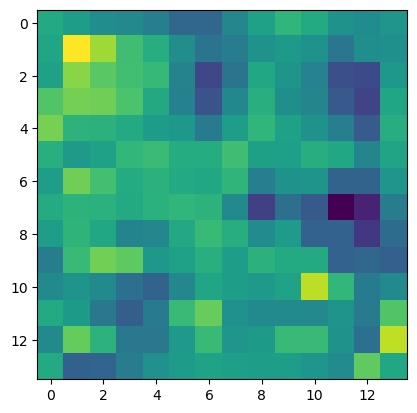

In [72]:
plt.imshow(activation_layer_28_inv[10,50].cpu().T)

In [147]:
for j, image in enumerate(activation_layer_36_inv):
    fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(10, 10))
    fig.subplots_adjust(right=0.85)

    # Create a shared colorbar
    vmin = min(d.min() for d in image[::4]) * 0.85
    vmin = -10
    vmax = max(d.max() for d in image[::4]) * 0.85
    vmax = 10
    cmap = plt.get_cmap('viridis')

    for i, ax in enumerate(axes.flat):
        im = ax.imshow(image[::4][i].T, vmin=vmin, vmax=vmax, cmap=cmap)
        if i == 0: im = ax.imshow(images[j])
        ax.set_xticks([])
        ax.set_yticks([])

    # Adjust the colorbar to be placed correctly
    cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    fig.suptitle('Layer 36 activation after inverse transformation', y=0.9)
    plt.savefig(f'../data/temp_layer36/figure_layer36_{j:03}.png')
    plt.close()

In [148]:
from PIL import Image

file_names = [f"../data/temp_layer36/figure_layer36_{i:03}.png" for i in range(180)]

# Read images and create animation
layer_36_images = [Image.open(f) for f in file_names]

# Adjust the fps value as needed
layer_36_images[0].save('../data/layer36_inv_output.gif', save_all=True, append_images=layer_36_images[1:], duration=1.5, loop=0)

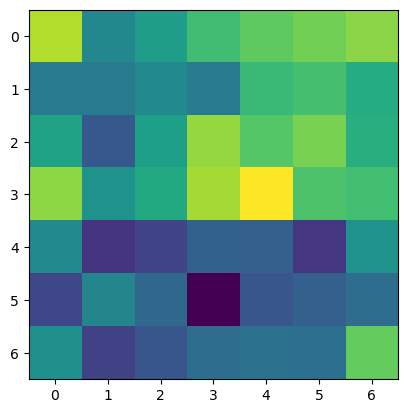

In [64]:
plt.imshow(activation_layer_36_inv[100,50].cpu().T)